In [14]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [15]:
positive_dir = Path(r"F:\BE FInal year projecr\Historical Building Cracks\crack")
negative_dir = Path(r"F:\BE FInal year projecr\Historical Building Cracks\non-crack")

In [16]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [17]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")


all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

Filepath     Label
0     F:\BE FInal year projecr\Historical Building C...  POSITIVE
1     F:\BE FInal year projecr\Historical Building C...  POSITIVE
2     F:\BE FInal year projecr\Historical Building C...  POSITIVE
3     F:\BE FInal year projecr\Historical Building C...  POSITIVE
4     F:\BE FInal year projecr\Historical Building C...  NEGATIVE
...                                                 ...       ...
5410  F:\BE FInal year projecr\Historical Building C...  POSITIVE
5411  F:\BE FInal year projecr\Historical Building C...  NEGATIVE
5412  F:\BE FInal year projecr\Historical Building C...  NEGATIVE
5413  F:\BE FInal year projecr\Historical Building C...  POSITIVE
5414  F:\BE FInal year projecr\Historical Building C...  NEGATIVE

[5415 rows x 2 columns]

In [18]:
train_df, test_df = train_test_split(
    all_df.sample(5400, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

Image data genration and convert to training and testing of augmented images


In [19]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [20]:
#train data
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 3024 validated image filenames belonging to 2 classes.


In [21]:
#validation data

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 755 validated image filenames belonging to 2 classes.


In [22]:
#test data
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 1621 validated image filenames belonging to 2 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate schedule
learning_rate_schedule = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,          # Lower bound on the learning rate
    verbose=1             # Verbosity mode
)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)  
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Adding more convolutional layers
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)  
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Adding more dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

opt = RMSprop(learning_rate=1e-4)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print(model.summary())






Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 64)        1849

In [24]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)


Epoch 1/20
95/95 [==============================] - 24s 240ms/step - loss: 0.5993 - accuracy: 0.6772 - val_loss: 0.4325 - val_accuracy: 0.8291
Epoch 2/20
95/95 [==============================] - 25s 266ms/step - loss: 0.4145 - accuracy: 0.8310 - val_loss: 0.3789 - val_accuracy: 0.8623
Epoch 3/20
95/95 [==============================] - 26s 276ms/step - loss: 0.3758 - accuracy: 0.8532 - val_loss: 0.3657 - val_accuracy: 0.8689
Epoch 4/20
95/95 [==============================] - 23s 243ms/step - loss: 0.3474 - accuracy: 0.8694 - val_loss: 0.3652 - val_accuracy: 0.8662
Epoch 5/20
95/95 [==============================] - 25s 263ms/step - loss: 0.3200 - accuracy: 0.8800 - val_loss: 0.3853 - val_accuracy: 0.8570
Epoch 6/20
95/95 [==============================] - 26s 274ms/step - loss: 0.3096 - accuracy: 0.8843 - val_loss: 0.2935 - val_accuracy: 0.8967
Epoch 7/20
95/95 [==============================] - 23s 247ms/step - loss: 0.2794 - accuracy: 0.9018 - val_loss: 0.2676 - val_accuracy: 0.9113

In [36]:
#plotting the loss

fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [27]:
#plotting the accuracy

import plotly.express as px

fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "Accuracy"},
    title="Training and Validation Accuracy Over Time"
)

fig.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

51/51 [==============================] - 6s 116ms/step - loss: 0.1346 - accuracy: 0.9574
Test Loss: 0.1346
Test Accuracy: 0.9574


In [29]:
# Generate predictions for the test dataset
predictions = (model.predict(test_data) > 0.5).astype("int32")

# Extract true labels from the test dataset
true_labels = test_data.labels

# Importing necessary libraries for classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", conf_matrix)

51/51 [==============================] - 5s 102ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       823
           1       0.96      0.95      0.96       798

    accuracy                           0.96      1621
   macro avg       0.96      0.96      0.96      1621
weighted avg       0.96      0.96      0.96      1621

Confusion Matrix:
 [[792  31]
 [ 38 760]]


In [32]:
model.save('crack_1new.h5')

# Download the model file
from IPython.display import FileLink
FileLink('crack_1new.h5')

C:\Users\HP\Documents\crack_1new.h5

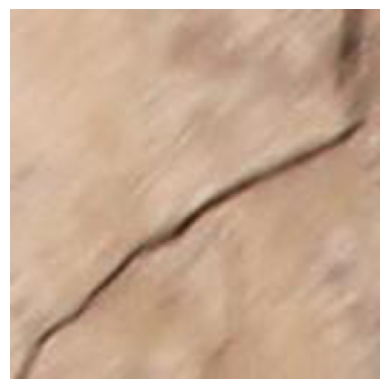

1/1 [==============================] - 1s 584ms/step
Prediction for C:\Users\HP\Downloads\test1\1.jpg: Crack Detected with Score 0.9869775772094727


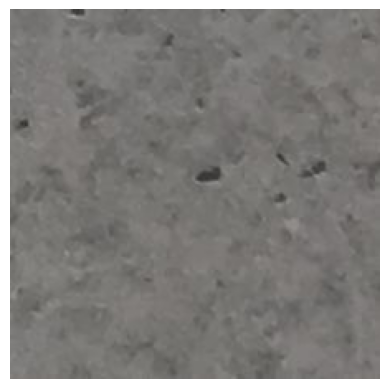

1/1 [==============================] - 0s 40ms/step
Prediction for C:\Users\HP\Downloads\test1\10.jpg: Crack Detected with Score 0.7856749296188354


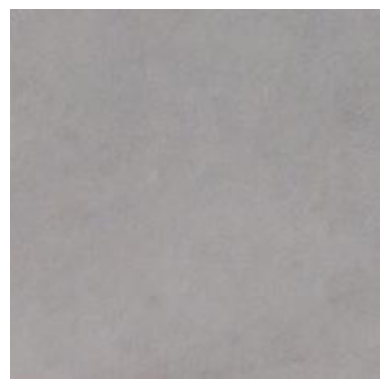

1/1 [==============================] - 0s 40ms/step
Prediction for C:\Users\HP\Downloads\test1\11.jpg: No Crack Detected with Score 0.030778665095567703


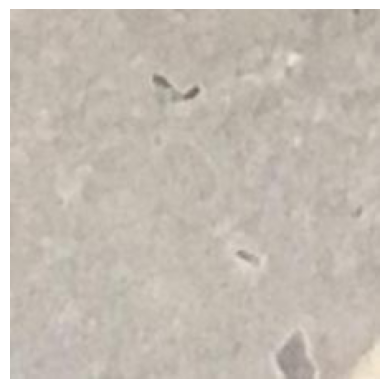

1/1 [==============================] - 0s 41ms/step
Prediction for C:\Users\HP\Downloads\test1\12.jpg: No Crack Detected with Score 0.11662784218788147


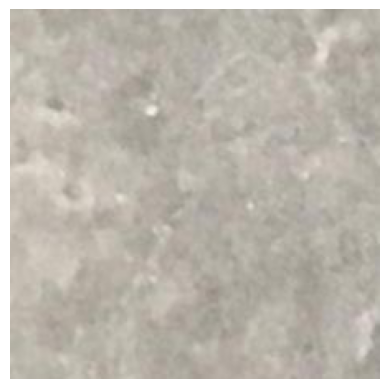

1/1 [==============================] - 0s 37ms/step
Prediction for C:\Users\HP\Downloads\test1\13.jpg: No Crack Detected with Score 0.056141454726457596


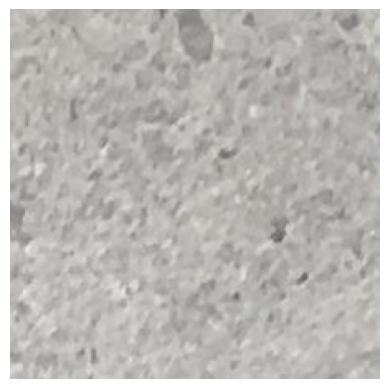

1/1 [==============================] - 0s 40ms/step
Prediction for C:\Users\HP\Downloads\test1\14.jpg: Crack Detected with Score 0.9760128855705261


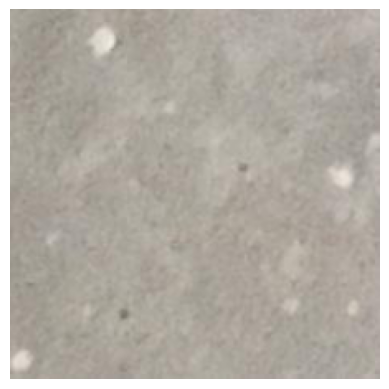

1/1 [==============================] - 0s 36ms/step
Prediction for C:\Users\HP\Downloads\test1\15.jpg: No Crack Detected with Score 0.06676997244358063


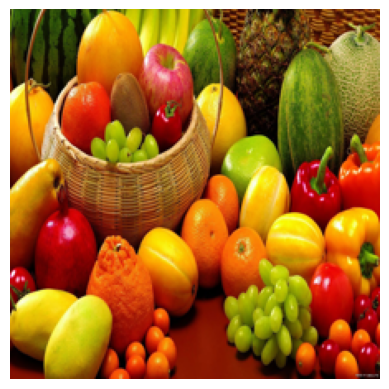

1/1 [==============================] - 0s 30ms/step
Prediction for C:\Users\HP\Downloads\test1\16.jpeg: No Crack Detected with Score 0.0737997367978096


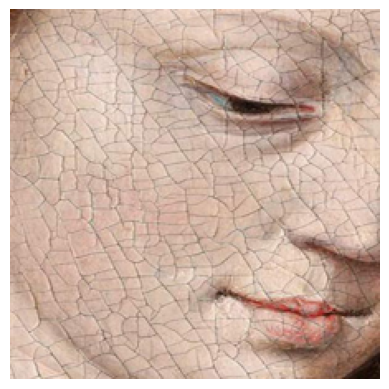

1/1 [==============================] - 0s 31ms/step
Prediction for C:\Users\HP\Downloads\test1\17.jpg: Crack Detected with Score 0.9255942702293396


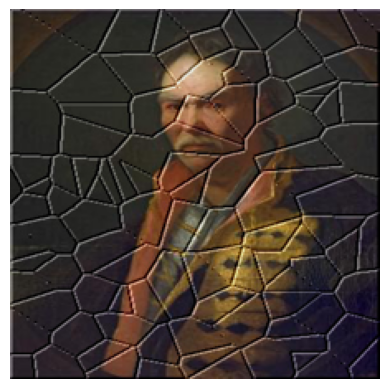

1/1 [==============================] - 0s 37ms/step
Prediction for C:\Users\HP\Downloads\test1\18.jpg: Crack Detected with Score 0.9964179396629333


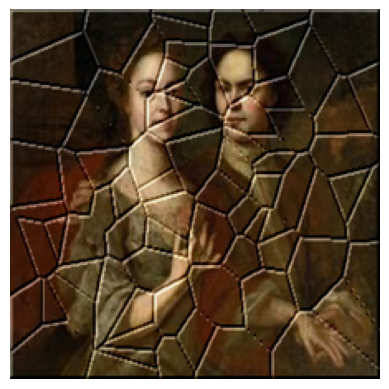

1/1 [==============================] - 0s 30ms/step
Prediction for C:\Users\HP\Downloads\test1\19.jpg: Crack Detected with Score 0.9976330399513245


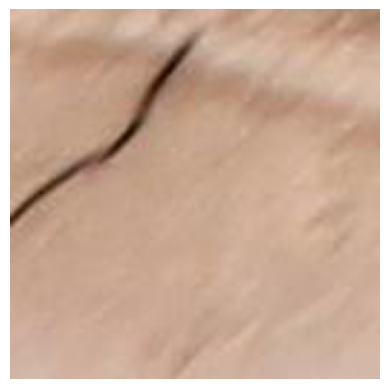

1/1 [==============================] - 0s 30ms/step
Prediction for C:\Users\HP\Downloads\test1\2.jpg: Crack Detected with Score 0.9945286512374878


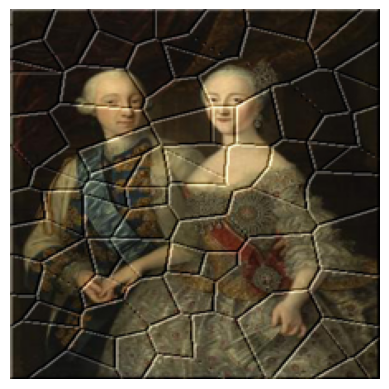

1/1 [==============================] - 0s 30ms/step
Prediction for C:\Users\HP\Downloads\test1\20.jpg: Crack Detected with Score 0.9324257373809814


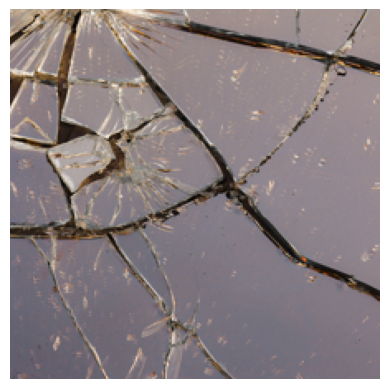

1/1 [==============================] - 0s 33ms/step
Prediction for C:\Users\HP\Downloads\test1\21.jpg: Crack Detected with Score 0.9998529553413391


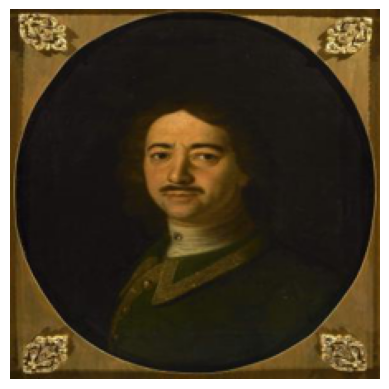

1/1 [==============================] - 0s 26ms/step
Prediction for C:\Users\HP\Downloads\test1\22.jpg: No Crack Detected with Score 0.3364918828010559


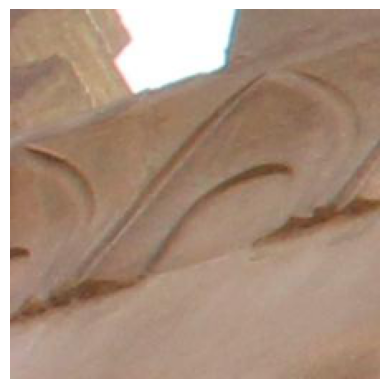

1/1 [==============================] - 0s 26ms/step
Prediction for C:\Users\HP\Downloads\test1\2460.jpg: Crack Detected with Score 0.9702234268188477


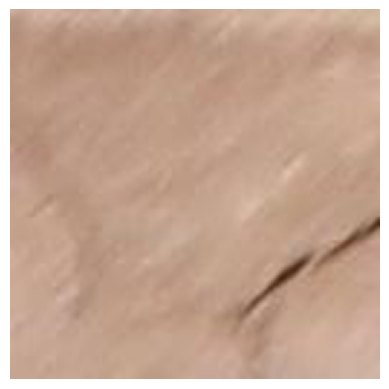

1/1 [==============================] - 0s 37ms/step
Prediction for C:\Users\HP\Downloads\test1\3.jpg: Crack Detected with Score 0.8599835634231567


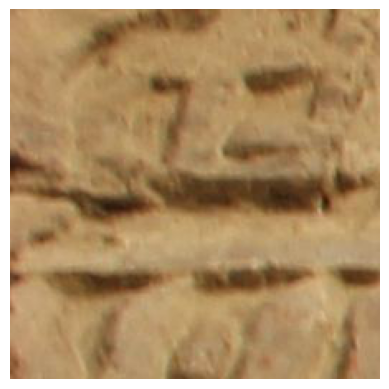

1/1 [==============================] - 0s 34ms/step
Prediction for C:\Users\HP\Downloads\test1\340.jpg: Crack Detected with Score 0.8653183579444885


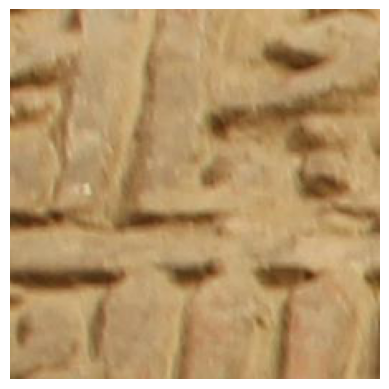

1/1 [==============================] - 0s 29ms/step
Prediction for C:\Users\HP\Downloads\test1\342.jpg: Crack Detected with Score 0.929465651512146


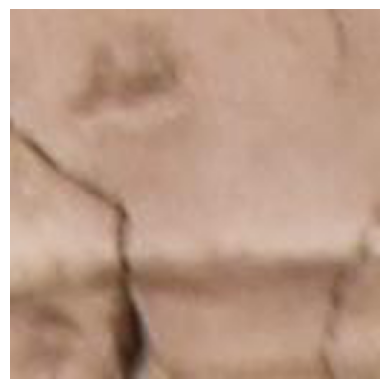

1/1 [==============================] - 0s 35ms/step
Prediction for C:\Users\HP\Downloads\test1\4.jpg: Crack Detected with Score 0.9893978834152222


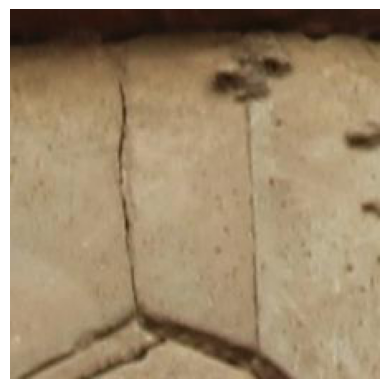

1/1 [==============================] - 0s 29ms/step
Prediction for C:\Users\HP\Downloads\test1\5.jpg: Crack Detected with Score 0.9915856719017029


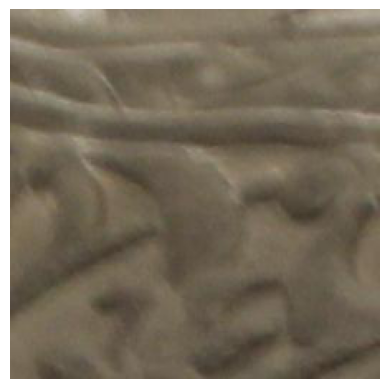

1/1 [==============================] - 0s 49ms/step
Prediction for C:\Users\HP\Downloads\test1\5011.jpg: No Crack Detected with Score 0.10807934403419495


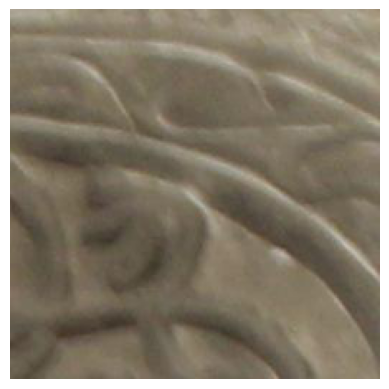

1/1 [==============================] - 0s 38ms/step
Prediction for C:\Users\HP\Downloads\test1\5012.jpg: No Crack Detected with Score 0.43894654512405396


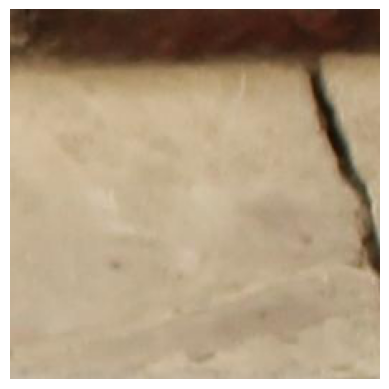

1/1 [==============================] - 0s 31ms/step
Prediction for C:\Users\HP\Downloads\test1\6.jpg: Crack Detected with Score 0.9544461965560913


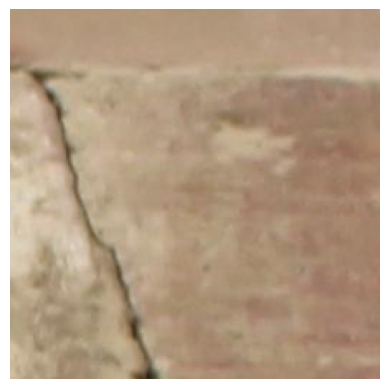

1/1 [==============================] - 0s 31ms/step
Prediction for C:\Users\HP\Downloads\test1\7.jpg: Crack Detected with Score 0.9965442419052124


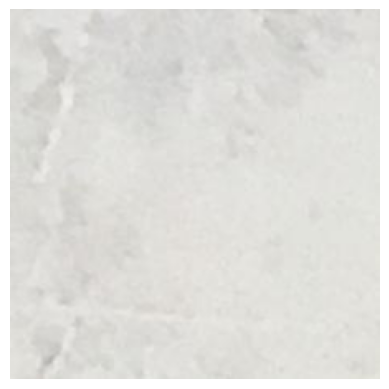

1/1 [==============================] - 0s 33ms/step
Prediction for C:\Users\HP\Downloads\test1\8.jpg: No Crack Detected with Score 0.04776092618703842


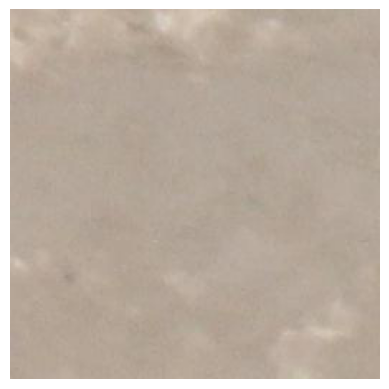

1/1 [==============================] - 0s 31ms/step
Prediction for C:\Users\HP\Downloads\test1\8791.jpg: No Crack Detected with Score 0.02019616588950157


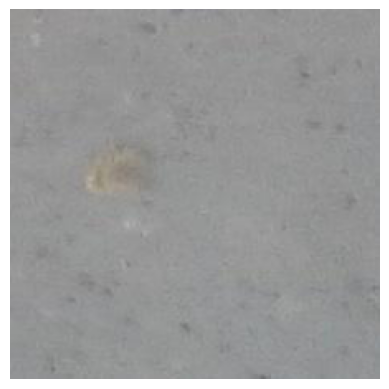

1/1 [==============================] - 0s 34ms/step
Prediction for C:\Users\HP\Downloads\test1\9.jpg: No Crack Detected with Score 0.04823875427246094
['Prediction for C:\\Users\\HP\\Downloads\\test1\\1.jpg: Crack Detected with Score 0.9869775772094727', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\10.jpg: Crack Detected with Score 0.7856749296188354', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\11.jpg: No Crack Detected with Score 0.030778665095567703', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\12.jpg: No Crack Detected with Score 0.11662784218788147', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\13.jpg: No Crack Detected with Score 0.056141454726457596', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\14.jpg: Crack Detected with Score 0.9760128855705261', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\15.jpg: No Crack Detected with Score 0.06676997244358063', 'Prediction for C:\\Users\\HP\\Downloads\\test1\\16.jpeg: No Crack Detected with Score 0.07379973679780

In [35]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os  # Importing the os module

def predict_crack(image_paths, model_path):
    results = []  # Initialize results list

    # Load your trained model
    model = tf.keras.models.load_model(model_path)

    for image_path in image_paths:
        # Load the image and resize it to match the model's input shape
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Ensure the size matches your model's input shape

        # Display the image using Matplotlib (optional)
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.show()

        # Convert the image to an array and normalize pixel values
        img_array = np.array(img)
        img_array = img_array / 255.0  # Normalize pixel values if your model was trained with normalized data

        # Add a batch dimension as the model expects batch input
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction on the image
        prediction = model.predict(img_array)

        # Interpret the prediction
        prediction_score = prediction[0][0]
        if prediction_score > 0.5:
            result = "Prediction for {}: Crack Detected with Score {}".format(image_path, prediction_score)
        else:
            result = "Prediction for {}: No Crack Detected with Score {}".format(image_path, prediction_score)
        results.append(result)
        print(result)

    return results

# Function to get all image file paths in a folder
def get_image_paths(folder_path):
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    return image_paths

# Example usage
folder_path = r"C:\Users\HP\Downloads\test1"
image_paths = get_image_paths(folder_path)
model_path = r"C:\Users\HP\Downloads\crack_1new.h5"
result = predict_crack(image_paths, model_path)

print(result)
